# Navigation of a Banana Collector

---

This notebook is the first Udacity Reinforcement Learning Nanodegree project. It uses the Unity ML-Agents environment.

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from DeepQNetwork_agent import Agent
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell,  you will watch an untrained agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

The section 4 deals with training this agent.

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. Training the agent

The below cells are used to train the agent. For this The environment is set in training mode through `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
env_info = env.reset(train_mode=True)[brain_name]

First let's instantiate an agent with some specific DQN architecture

In [7]:
agent = Agent(state_size=len(env_info.vector_observations[0]), action_size=brain.vector_action_space_size, seed=0, fc1=64, fc2=128, fc3=128, fc4=64, dueling = True, fcduel = 32)

QNetwork (5 layers, dueling:True) initialized with states space size 37 and 4 actions
QNetwork (5 layers, dueling:True) initialized with states space size 37 and 4 actions


Then the next cell code will define the training function and run it. The training will stop once the average score over 100 consecutive episodes reaches +13.0 and the trained weights will be written done in a file named 'checkpointN.pth' with N being the trial number passed as input argument to the qdn function.

In [8]:
def dqn(n_episodes=800, max_t=300, eps_start=1.0, eps_end=0.02, eps_decay=0.99, trial = 0):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        trial (int): index of the run used to append to the name of the output file
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(int(action))[brain_name]   # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)  #store action step and learn if sufficient memory
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint{}.pth'.format(trial))
            break
    return scores

scores = dqn(trial = 0)

Episode 100	Average Score: 1.03
Episode 200	Average Score: 2.70
Episode 300	Average Score: 7.22
Episode 400	Average Score: 10.57
Episode 496	Average Score: 13.03
Environment solved in 396 episodes!	Average Score: 13.03


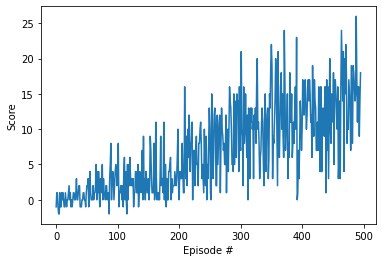

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Testing the trained agent (vanilla DQN)

The following uses a trained parameter set for an agent using a vanilla DQN.

In [11]:
# instantiate appropriate agent and load the weights from file
agent = Agent(state_size=len(env_info.vector_observations[0]), action_size=brain.vector_action_space_size, seed=0, fc1=64, fc2=128, fc3=128, fc4=64, dueling = False, fcduel=0)
agent.qnetwork_local.load_state_dict(torch.load('vanillaDQN.pth'))


env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
i = 0
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(int(action))[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    i = i+1
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}, number of steps: {}".format(score, i))

QNetwork (5 layers, dueling:False) initialized with states space size 37 and 4 actions
QNetwork (5 layers, dueling:False) initialized with states space size 37 and 4 actions
Score: 21.0, number of steps: 300


### Testing the trained Agent (Dueling DQN)

The following uses a trained parameter set for an agent using a dueling DQN.

In [14]:
# load the weights from file
agent = Agent(state_size=len(env_info.vector_observations[0]), action_size=brain.vector_action_space_size, seed=0, fc1=64, fc2=128, fc3=128, fc4=64, dueling = True, fcduel=128)
agent.qnetwork_local.load_state_dict(torch.load('duelingDQN.pth'))


env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
i = 0
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(int(action))[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    i = i+1
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}, number of steps: {}".format(score, i))

QNetwork (5 layers, dueling:True) initialized with states space size 37 and 4 actions
QNetwork (5 layers, dueling:True) initialized with states space size 37 and 4 actions
Score: 15.0, number of steps: 300


Once done, let's close the environment.

In [15]:
env.close()